*I tried to predict emotion classification with CatBoostClassifier.*

* I applied several <b>preprocessing</b> operations (I tried stemming and lemmatization, but there was no betterment in the F1 score),
* I used <b>a pretrained embeddings</b> for the text feature extraction stage [1],
* <b>PCA for dimensionality reduction </b> (applied the output of pretrained embeddings with 300 components),
* Used a tuned <b> CatBoostClassifier</b> for rating predictions (tuned with optuna)

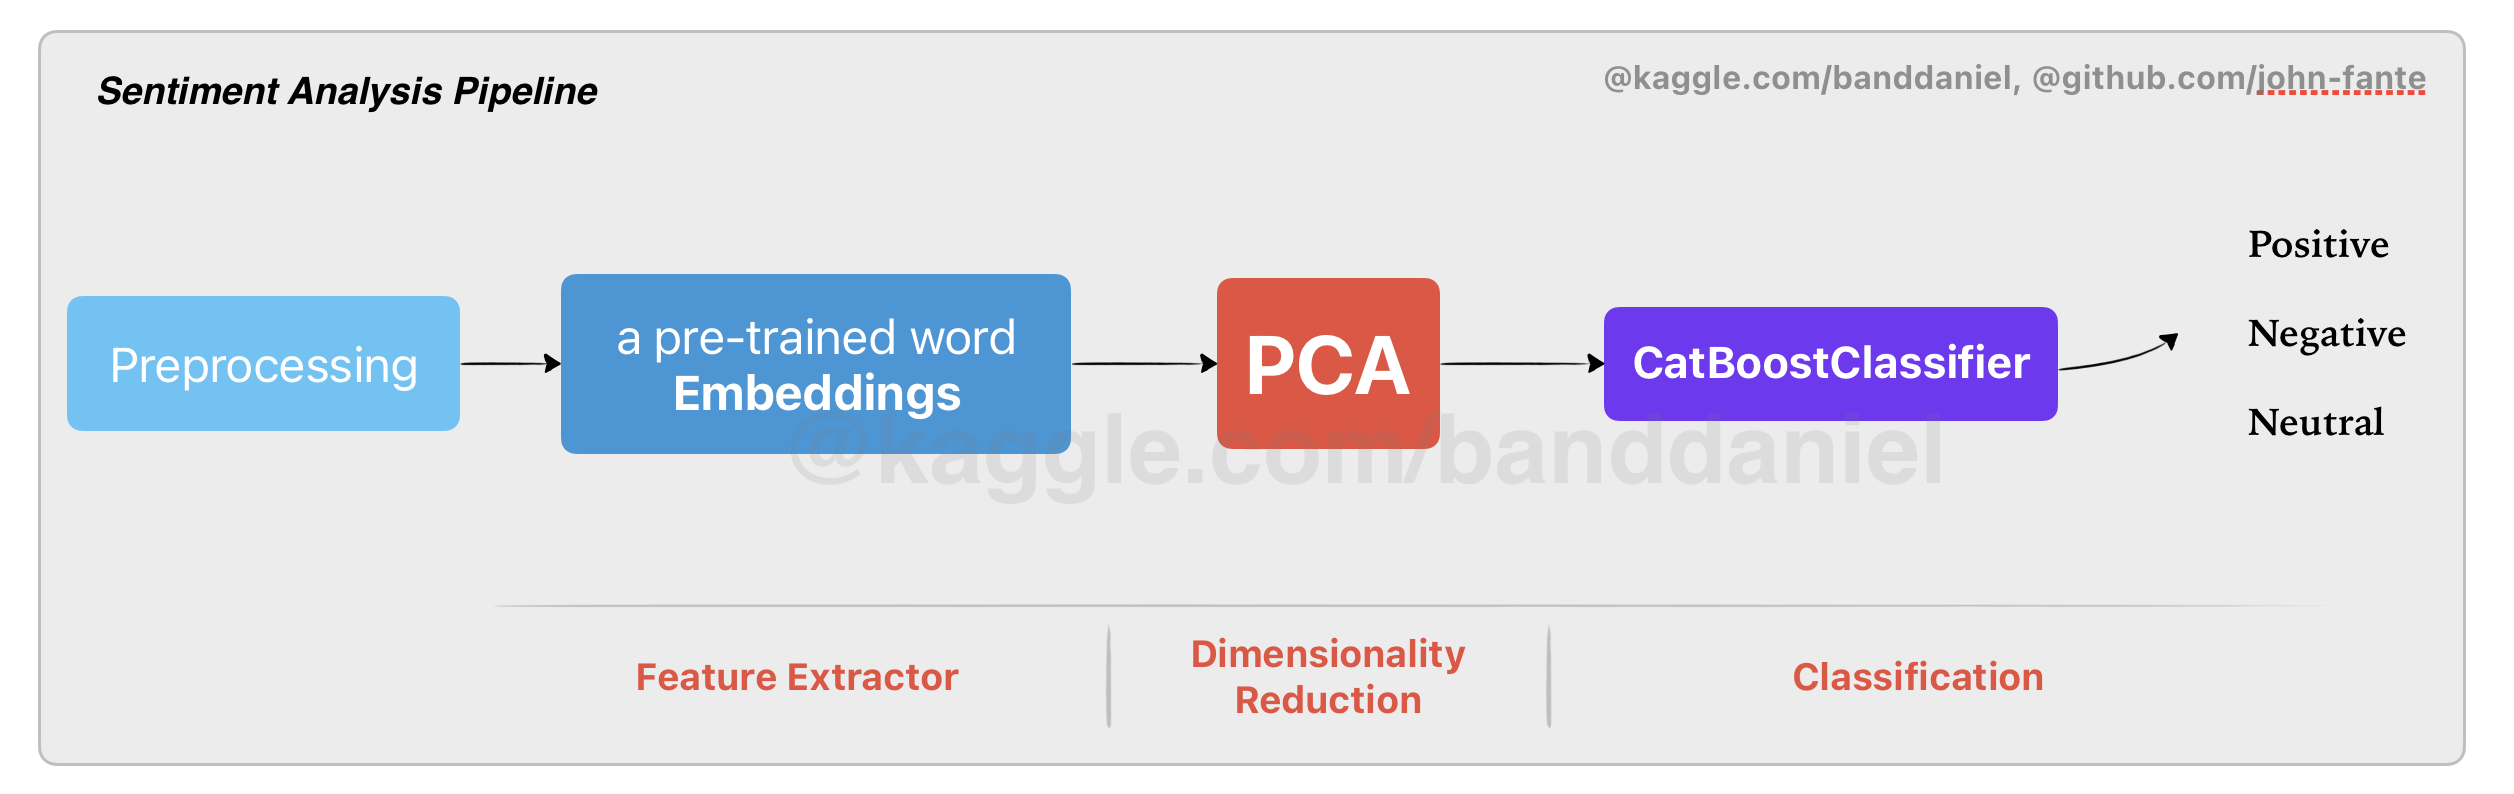
*Figure 1: proposed classification pipeline*


## My Another Projects
* [Gemma 2B Text Summarization w/Zero-Shot Prompting](https://www.kaggle.com/code/banddaniel/gemma-2b-text-summarization-w-zero-shot-prompting)
* [Rating Prediction w/SentenceTransformer, CatBoost](https://www.kaggle.com/code/banddaniel/rating-prediction-w-sentencetransformer-catboost)

## References
1. https://huggingface.co/sentence-transformers/all-mpnet-base-v2

In [1]:
from IPython.display import clear_output
!pip install sentence-transformers
clear_output()

In [2]:
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import  stopwords
import string
from colorama import Fore, Back, Style

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from catboost import CatBoostClassifier

from sentence_transformers import SentenceTransformer

# feature extractor
emmedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# <span style="color:#e74c3c;"> Reading </span> Data

In [3]:
data = pd.read_csv('/kaggle/input/sentiment-analysis/sentiment_analysis.csv')
data.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


# <span style="color:#e74c3c;"> Preprocessing </span>

In [4]:
# preprocessing functions
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


# applying preprocessing functions
data_processed = data.copy()
data_processed['text'] = data_processed['text'].apply(text_preprocessing).apply(drop_stopwords)

data_processed.head()


# label encoding
LE = LabelEncoder()
data_processed['Encoded sentiment'] = LE.fit_transform(data_processed['sentiment'])

In [5]:
data_processed.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform,Encoded sentiment
0,2018,8,18,morning,great day looks like dream,positive,Twitter,2
1,2018,8,18,noon,feel sorry miss sea beach,positive,Facebook,2
2,2017,8,18,night,angry,negative,Facebook,0
3,2022,6,8,morning,attend class listening teachers reading slide ...,negative,Facebook,0
4,2022,6,8,noon,want go let go,negative,Instagram,0


In [6]:
# train and test splitting
type_train_data, type_test_data = train_test_split(data_processed, test_size = 0.2, random_state = 99)

type_train_data = type_train_data.reset_index(drop = True)
type_test_data = type_test_data.reset_index(drop = True)

# <span style="color:#e74c3c;"> SentenceTransformer </span> Feature Extractor

In [7]:
# creating text features (768 features)

train_embeddings = emmedding_model.encode(list(type_train_data['text'].values), show_progress_bar = True)
test_embeddings = emmedding_model.encode(list(type_test_data['text'].values), show_progress_bar = True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

# <span style="color:#e74c3c;"> Dimensionality </span> Reduction

In [8]:
pca = PCA(300)

# last text features
train_pca = pca.fit_transform(train_embeddings)
test_pca = pca.transform(test_embeddings)

train_pca.shape

(399, 300)

In [9]:
X_train = train_pca
y_train = type_train_data['Encoded sentiment']

X_test = test_pca
y_test = type_test_data['Encoded sentiment']

# <span style="color:#e74c3c;"> CatBoostClassifier </span> 

In [10]:
# a tuned model
model = CatBoostClassifier(iterations = 989, learning_rate = 0.09369220945334325, depth = 4, l2_leaf_reg = 0.0028247153516532124,
                           bootstrap_type = 'Bayesian', random_strength = 0.11713631012845617, bagging_temperature =  4.309702866146159,
                           od_type =  'IncToDec', od_wait = 41, verbose = 200)

# training
model.fit(X_train, y_train)

0:	learn: 1.0900009	total: 122ms	remaining: 2m
200:	learn: 0.1476984	total: 6.04s	remaining: 23.7s
400:	learn: 0.0310830	total: 12.2s	remaining: 17.8s
600:	learn: 0.0066214	total: 18s	remaining: 11.6s
800:	learn: 0.0015290	total: 23.8s	remaining: 5.58s
988:	learn: 0.0004935	total: 30.4s	remaining: 0us


# <span style="color:#e74c3c;"> Test </span>  Predictions

In [11]:
# Predictions and scores

test_pred = model.predict(X_test)

mse = mean_squared_error(y_test, test_pred)
f1 = f1_score(y_test, test_pred, average = 'weighted')
acc = accuracy_score(y_test, test_pred)
cm = confusion_matrix(y_test, test_pred)

print('Mean Squared Error :\t{0:.5f}'.format(mse))
print('Weighted F1 Score :\t{0:.3f}'.format(f1))
print('Accuracy Score :\t{0:.3f} %'.format(acc*100))

Mean Squared Error :	0.41000
Weighted F1 Score :	0.703
Accuracy Score :	71.000 %


# <span style="color:#e74c3c;"> Test Confusion </span> Matrix

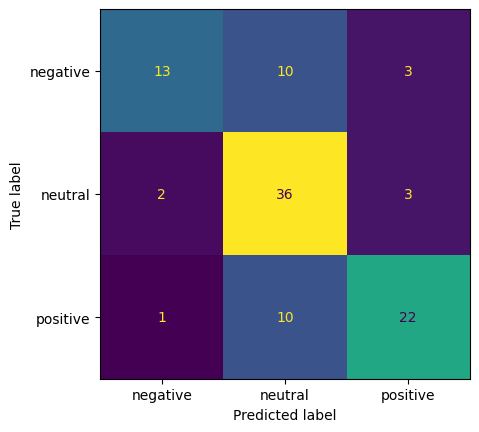

In [12]:
cmd = ConfusionMatrixDisplay(cm, display_labels = list(LE.classes_))
cmd.plot(colorbar = False)

# <span style="color:#e74c3c;"> Test Classification </span> Report

In [13]:
clf = classification_report(y_test, test_pred, target_names = list(LE.classes_))
print(clf)

              precision    recall  f1-score   support

    negative       0.81      0.50      0.62        26
     neutral       0.64      0.88      0.74        41
    positive       0.79      0.67      0.72        33

    accuracy                           0.71       100
   macro avg       0.75      0.68      0.69       100
weighted avg       0.73      0.71      0.70       100



# <span style="color:#e74c3c;"> Test Sample </span> Prediction

In [14]:
# a function for showing a test sample and prediction

def create_test_pipeline(SEED):
    sample = type_test_data.sample(1, random_state = SEED)
    
    print(Fore.RED + '(RAW TEXT) {0} '.format(data.iloc[sample.index]['text'].values[0]) + '(TRUE CLASS: {0})'.format(LE.classes_[test_pred[sample.index]][0][0]) )
    print(Fore.BLUE + '(PROCESSED TEXT) {0}'.format(data_processed.iloc[sample.index]['text'].values[0]) + ' (PRED CLASS: {0})'.format(LE.classes_[test_pred[sample['Encoded sentiment']]][0][0]))

In [21]:
create_test_pipeline(129)

(RAW TEXT) See you in the cloud (TRUE CLASS: neutral)
(PROCESSED TEXT) see cloud (PRED CLASS: neutral)


In [16]:
create_test_pipeline(22)

(RAW TEXT) Don't angry me (TRUE CLASS: neutral)
(PROCESSED TEXT) angry (PRED CLASS: neutral)


In [17]:
create_test_pipeline(397)

(RAW TEXT) My Sharpie is running DANGERously low on ink (TRUE CLASS: positive)
(PROCESSED TEXT) sharpie running dangerously low ink (PRED CLASS: neutral)


In [18]:
create_test_pipeline(937)

(RAW TEXT) Always love everyone, love all animals. Most important love your parents (TRUE CLASS: positive)
(PROCESSED TEXT) always love everyone love animals important love parents (PRED CLASS: neutral)
